In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np  # needed for -np.log10

# PyDESeq2 (DESeq2 implementation in Python)
from pydeseq2.utils import load_example_data
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats  # updated import for v0.5.2


In [13]:
# Load counts (genes = columns, samples = rows)
counts_df = load_example_data()

# Create metadata (half Control, half Treatment)
metadata_df = pd.DataFrame({
    "condition": ["Control"] * (counts_df.shape[0] // 2) + ["Treatment"] * (counts_df.shape[0] - counts_df.shape[0] // 2)
}, index=counts_df.index)  # samples as index

print("Counts data:")
print(counts_df.head())

print("\nMetadata:")
print(metadata_df.head())


Counts data:
         gene1  gene2  gene3  gene4  gene5  gene6  gene7  gene8  gene9  gene10
sample1     12     21      4    130     18      0     16     54     49       3
sample2      1     44      2     63     11     10     70     32     57       9
sample3      4      4     11    180     21      3     28     34     65       2
sample4      1     10      2    100     44      9     28     16     33       9
sample5      1     11      6    135     16      2     32     29     31       5

Metadata:
        condition
sample1   Control
sample2   Control
sample3   Control
sample4   Control
sample5   Control


In [16]:
# ================================
# 2. Build DESeq2 Dataset
# ================================

dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata_df,        # now has same number of rows as samples
    design_factors="condition"
)

# Run the DESeq2 pipeline
dds.deseq2()

Using None as control genes, passed at DeseqDataSet initialization


/var/folders/57/_ymgbr_x58n27ygw18b1mn7w0000gn/T/ipykernel_23025/408056837.py:5: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting dispersion trend curve...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.



In [17]:
# ================================
# 3. Differential Expression Analysis
# ================================
# Compare Treatment vs Control
stat_res = DeseqStats(dds, contrast=["condition", "Treatment", "Control"])
stat_res.summary()  # prints result summary

# Get results as a DataFrame
results_df = stat_res.results_df
print("\nDifferential Expression Results (first 10 rows):")
print(results_df.head(10))

Log2 fold change & Wald test p-value: condition Treatment vs Control
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
gene1     8.541317        0.632812  0.289101  2.188898  0.028604  0.064150
gene2    21.281239        0.538552  0.149963  3.591236  0.000329  0.001646
gene3     5.010123       -0.632830  0.295236 -2.143476  0.032075  0.064150
gene4   100.517961       -0.412102  0.118629 -3.473868  0.000513  0.001710
gene5    27.142450        0.582065  0.154706  3.762409  0.000168  0.001646
gene6     5.413043        0.001457  0.310311  0.004696  0.996253  0.996253
gene7    28.294023        0.134338  0.149945  0.895917  0.370297  0.411441
gene8    40.358344       -0.270656  0.136401 -1.984261  0.047227  0.078711
gene9    37.166183       -0.212715  0.133243 -1.596437  0.110391  0.143147
gene10   11.589325        0.386011  0.244588  1.578207  0.114518  0.143147

Differential Expression Results (first 10 rows):
          baseMean  log2FoldChange     lfcSE      stat  

Running Wald tests...
... done in 0.01 seconds.



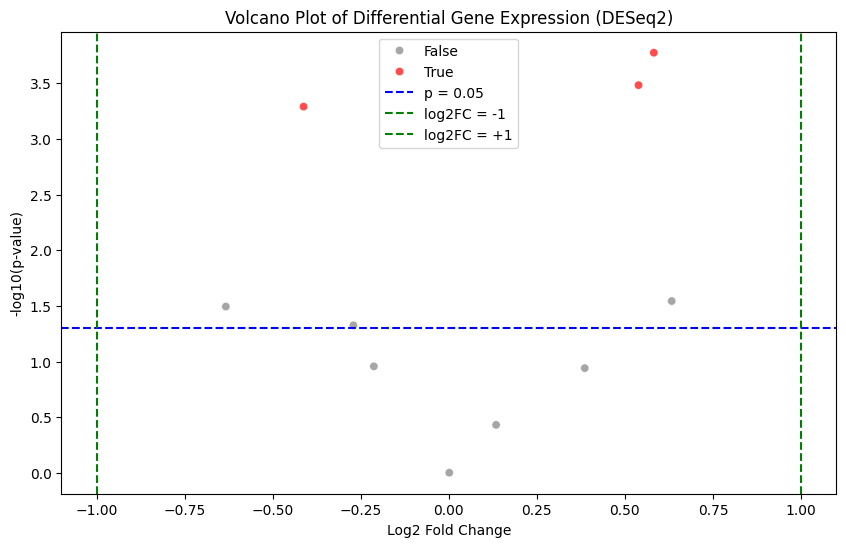

In [32]:
# ================================
# 4. Volcano Plot
# ================================
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=results_df,
    x="log2FoldChange", 
    y=-np.log10(results_df["pvalue"]),
    hue=results_df["padj"] < 0.05,
    palette={True: "red", False: "grey"},
    alpha=0.7
)

# Add cutoffs
plt.axhline(-np.log10(0.05), color="blue", linestyle="--", label="p = 0.05")
plt.axvline(-1, color="green", linestyle="--", label="log2FC = -1")
plt.axvline(1, color="green", linestyle="--", label="log2FC = +1")

plt.xlabel("Log2 Fold Change")
plt.ylabel("-log10(p-value)")
plt.title("Volcano Plot of Differential Gene Expression (DESeq2)")
plt.legend()
plt.show()

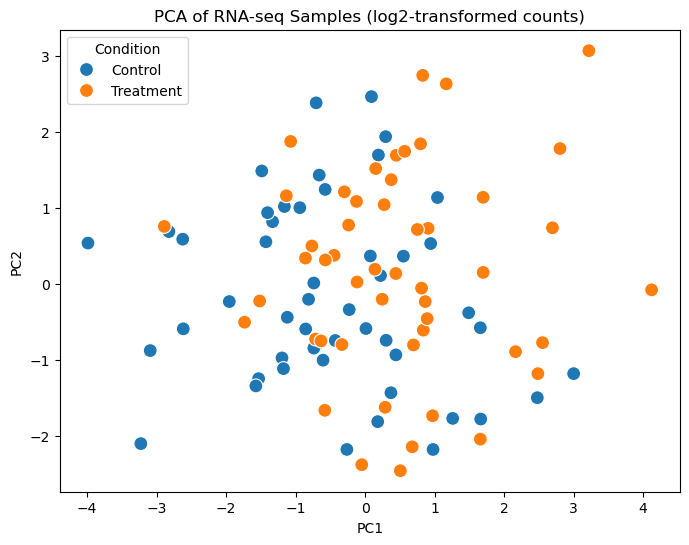

In [18]:
# ================================
# 5. PCA Plot of Samples
# ================================
# Log-transform counts (add 1 to avoid log(0))
norm_counts = np.log2(counts_df + 1)

# Run PCA
pca = PCA(n_components=2)
pc = pca.fit_transform(norm_counts)

# Create DataFrame for plotting
pca_df = pd.DataFrame(pc, columns=["PC1", "PC2"], index=counts_df.index)
pca_df["Condition"] = metadata_df["condition"]

# Plot PCA
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Condition", s=100)
plt.title("PCA of RNA-seq Samples (log2-transformed counts)")
plt.show()